# Llibreries

In [4]:
# Import llibreries

import json
import os
import sys
import time
import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# Carregar dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [5]:
#Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'
fitxer_dades_csv = 'SCM_T_Z1.csv'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)

# Llegir el fitxer CSV i importar les dades

df = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df['data'] = pd.to_datetime(df['data'], utc=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8
...,...,...
230024,2024-12-31 19:00:00+00:00,0.1
230025,2024-12-31 20:00:00+00:00,-0.6
230026,2024-12-31 21:00:00+00:00,-0.6
230027,2024-12-31 22:00:00+00:00,-0.7


# Primera visualització de les dades i neteja

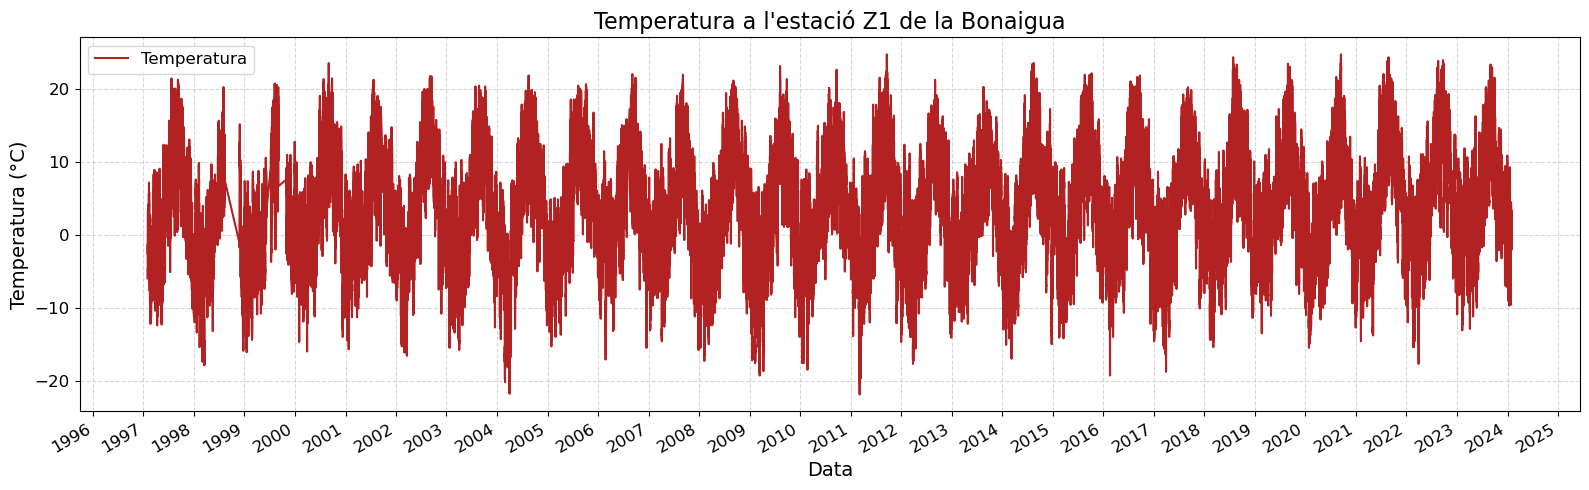

In [12]:
# Grafic de les dades

plt.figure(figsize=(16, 5))
plt.plot(df['data'], df['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l'eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [13]:
# Eliminem les dades del 2000 cap enrere ja que hi ha una discontinuïtat
df = df[df['data'] >= '2000-01-01']

# Restablir l'index
df = df.reset_index(drop=True)

df.head(5)

,data,valor
0,2000-01-01 00:00:00+00:00,-4.0
1,2000-01-01 01:00:00+00:00,-4.1
2,2000-01-01 02:00:00+00:00,-3.9
3,2000-01-01 03:00:00+00:00,-4.0
4,2000-01-01 04:00:00+00:00,-4.1


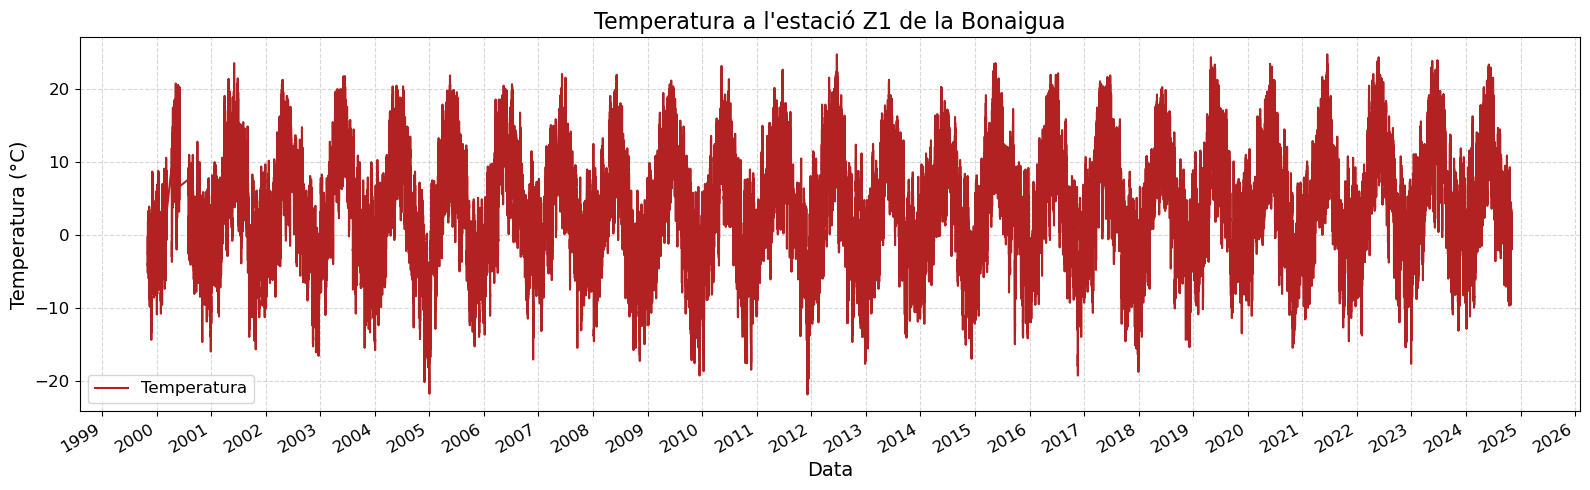

In [14]:
# Grafic de les dades

plt.figure(figsize=(16, 5))
plt.plot(df['data'], df['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l'eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [15]:
# Agafar només les dades corresponents als hiverns i posar-les en un nou dataframe
# Les dates dels hiverns seran del 1 de desembre al 31 de març
df_hiverns = df[(df['data'].dt.month >= 11) | (df['data'].dt.month <= 2)]
 
# Restablir l'index
df_hiverns = df_hiverns.reset_index(drop=True)

df_hiverns.head()

,data,valor
0,2000-01-01 00:00:00+00:00,-4.0
1,2000-01-01 01:00:00+00:00,-4.1
2,2000-01-01 02:00:00+00:00,-3.9
3,2000-01-01 03:00:00+00:00,-4.0
4,2000-01-01 04:00:00+00:00,-4.1


In [18]:
print(df_hiverns['valor'].min())
print(df_hiverns['valor'].max())

-21.9
17.3


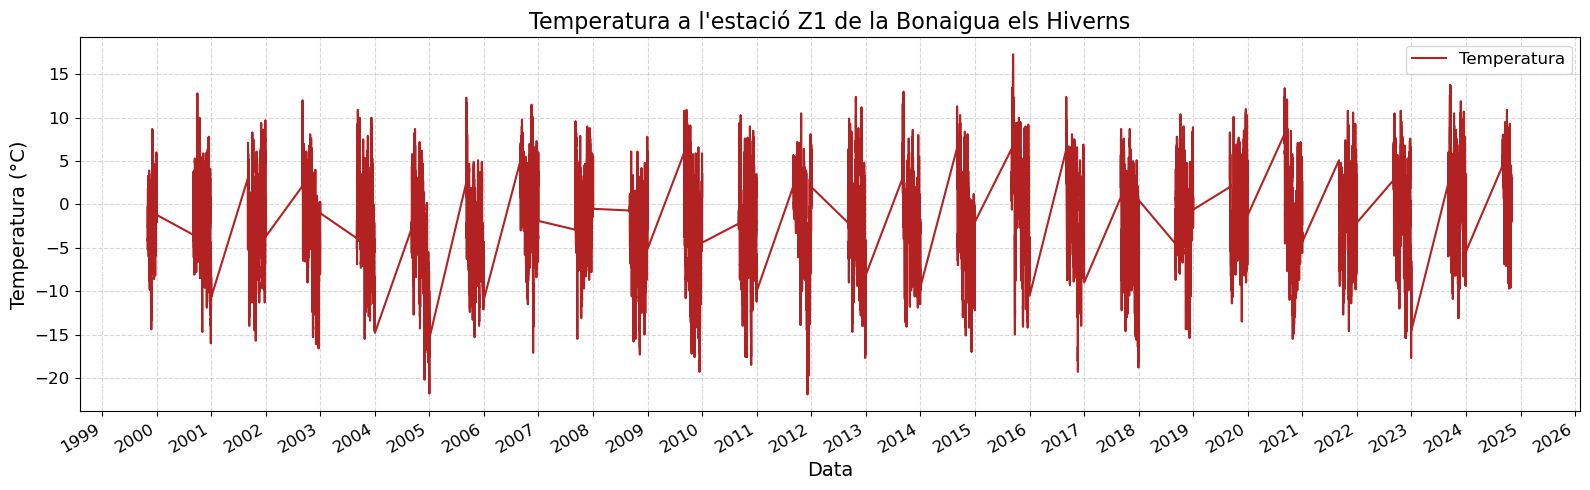

In [17]:
# Grafic de les dades

plt.figure(figsize=(16, 5))
plt.plot(df_hiverns['data'], df_hiverns['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua els Hiverns', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l'eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


# Probabilitats Markov

In [5]:
# Establir llindars de Temperatura per a cada situació discreta
# 1. Temperatura mes baixa de 1 grau dona neu
# 2. Temperatura entre 1 i 2 graus dona aiguaneu
# 3. Temperatura superior a 2 graus dona pluja

# Afegim una columna amb la categoria de precipitació N,A,P

df_hiverns.loc[:, 'precipitacio'] = pd.cut(df_hiverns['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])

df_hiverns.head()

,data,valor,precipitacio
0,2000-01-01 00:00:00+00:00,-4.0,N
1,2000-01-01 01:00:00+00:00,-4.1,N
2,2000-01-01 02:00:00+00:00,-3.9,N
3,2000-01-01 03:00:00+00:00,-4.0,N
4,2000-01-01 04:00:00+00:00,-4.1,N


In [6]:
# Separem les dades de train i test
# Train seran les dades que farem servir per calcular les probabilitats de transició
# Test seran les sobre les que pronosticarem la categoria i les compararem amb les reals

# Ho fem només de l'hivern com a estació ja que es una manera que hi hagi transicions, del contrari practicament sempre seria la mateixa categoria

# El test serà l'hivern 2023-2024
# El train seran tota la resta d'hiverns fins el de test, es a dir del 2000-2001 al 2022-2023


# Any de referència (any del gener/febrer de l'hivern de test)
any = 2024

# TEST: hivern novembre 2023 → febrer 2024
df_test_hiverns = df_hiverns[
    ((df_hiverns['data'].dt.year == any - 1) & (df_hiverns['data'].dt.month >= 11)) |
    ((df_hiverns['data'].dt.year == any) & (df_hiverns['data'].dt.month <= 2))
].reset_index(drop=True)

# TRAIN: tots els hiverns previs (de 2000–2001 fins 2022–2023 inclòs)
df_train_hiverns = df_hiverns[
    (((df_hiverns['data'].dt.month >= 11) & (df_hiverns['data'].dt.year < any - 1)) |
     ((df_hiverns['data'].dt.month <= 2) & (df_hiverns['data'].dt.year < any)))
].reset_index(drop=True)

# Comprovació
print(f"Dades d'entrenament: {len(df_train_hiverns)} valors")
print(f"Dades de test: {len(df_test_hiverns)} valors")
print("Interval train:", df_train_hiverns['data'].min(), "→", df_train_hiverns['data'].max())
print("Interval test:", df_test_hiverns['data'].min(), "→", df_test_hiverns['data'].max())


Dades d'entrenament: 67630 valors
Dades de test: 2904 valors
Interval train: 2000-01-01 00:00:00+00:00 → 2023-02-28 23:00:00+00:00
Interval test: 2023-11-01 00:00:00+00:00 → 2024-02-29 23:00:00+00:00


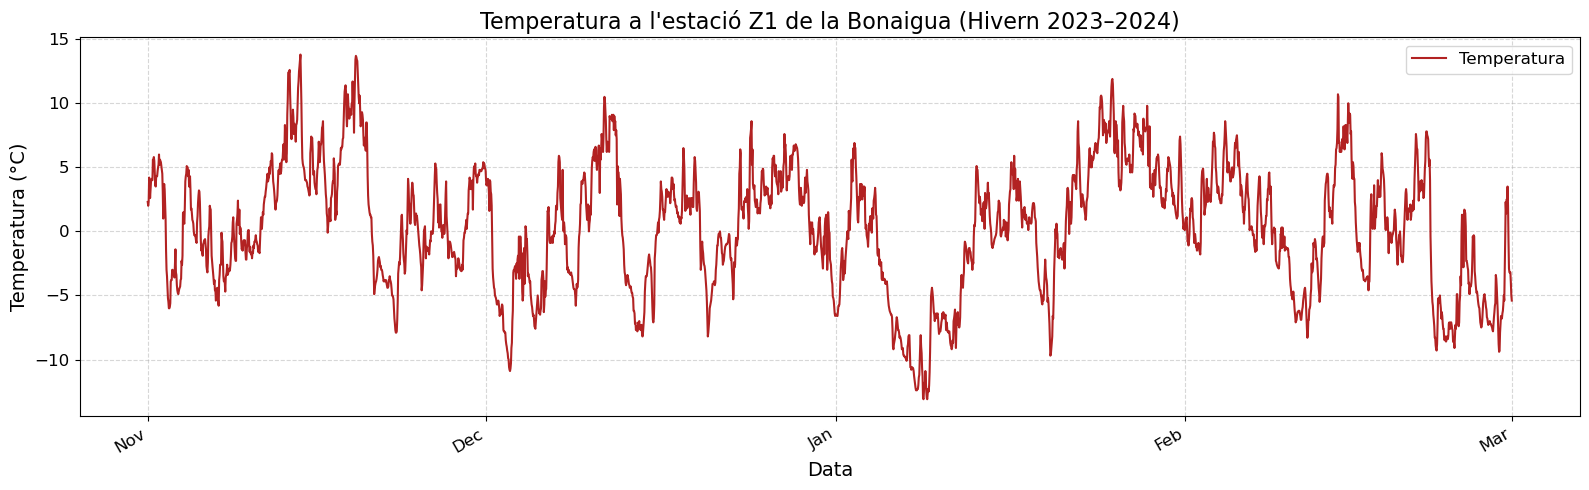

In [7]:
# Graficar la temperatura
plt.figure(figsize=(16, 5))

# Línia de temperatura
plt.plot(df_test_hiverns['data'], df_test_hiverns['valor'],
         label='Temperatura', color='firebrick', linewidth=1.5)

# Títol i eixos
plt.title("Temperatura a l'estació Z1 de la Bonaigua (Hivern 2023–2024)", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Temperatura (°C)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Format de dates: només el nom del mes al principi de cada mes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Ex: Nov, Dec, Jan

plt.gcf().autofmt_xdate()

# Llegenda i graella
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [8]:
# Per calcular les probabilitats de transició, probabilitats condicionades, necesitem crear una nova columna que contingui l'estat anterior de la precipitació
# i la columna 'precipitacio' que conté l'estat actual de la precipitació
# La columna 'precipitacio' conté l'estat actual de la precipitació
# La columna 'precipitacio_anterior' conté l'estat anterior de la precipitació

df_train_hiverns['precipitacio_anterior'] = df_train_hiverns['precipitacio'].shift(1)

# Assumim que el primer valor de la columna 'precipitacio_anterior' es el mateix que el primer valor de la columna 'precipitacio'
df_train_hiverns['precipitacio_anterior'].fillna(df_train_hiverns['precipitacio'].iloc[0], inplace=True)

In [9]:
# Calcular las probabilitat de cada tipus de precipitació

prob_precipitacio = df_train_hiverns['precipitacio'].value_counts(normalize=True)

prob_precipitacio

precipitacio
N    0.733432
P    0.205501
A    0.061068
Name: proportion, dtype: float64

In [10]:
# Calcular les transicions: com passar d'un estat a un altre
transicions = pd.crosstab(df_train_hiverns['precipitacio_anterior'], df_train_hiverns['precipitacio'], normalize='index')

transicions

precipitacio,N,A,P
precipitacio_anterior,,,
N,0.971715,0.021814,0.006472
A,0.280872,0.487167,0.231961
P,0.017485,0.074543,0.907972


In [11]:
print("Suma per fila:")
print(transicions.sum(axis=1))  # Ha de donar tot 1.0


Suma per fila:
precipitacio_anterior
N    1.0
A    1.0
P    1.0
dtype: float64


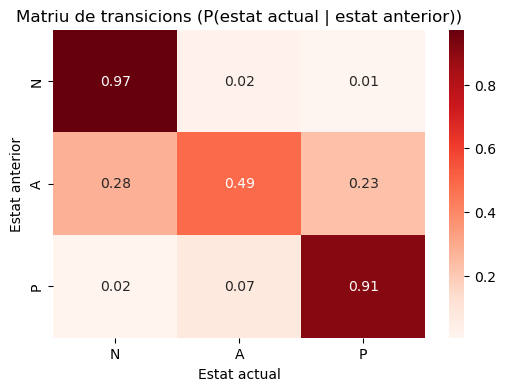

In [69]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(transicions, annot=True, cmap="Reds", fmt=".2f")
plt.title("Matriu de transicions (P(estat actual | estat anterior))")
plt.xlabel("Estat actual")
plt.ylabel("Estat anterior")
plt.show()

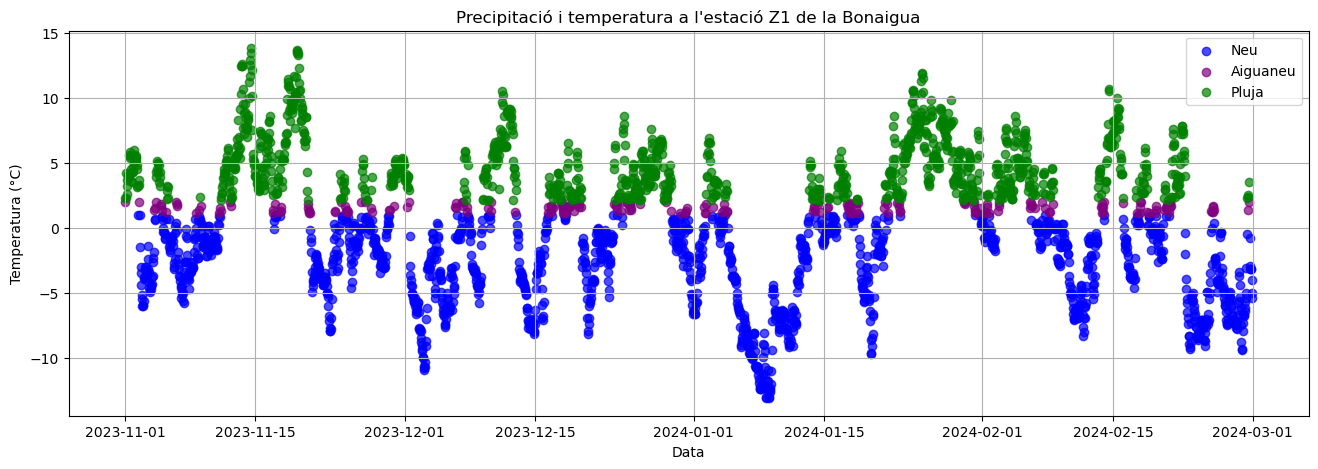

In [13]:
colors = {'N': 'blue', 'A': 'purple', 'P': 'green'}
labels = {'N': 'Neu', 'A': 'Aiguaneu', 'P': 'Pluja'}

plt.figure(figsize=(16,5))
for estat in ['N', 'A', 'P']:
    subset = df_test_hiverns[df_test_hiverns['precipitacio'] == estat]
    plt.scatter(subset['data'], subset['valor'], label=labels[estat], color=colors[estat], alpha=0.7)

plt.title("Precipitació i temperatura a l'estació Z1 de la Bonaigua")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()



# Simulació de la cadena de Markov

In [26]:
# Fem la prediccio estocastica amb la cadena de Markov

# Inicialitzem la llista de prediccions
prediccions_estoc = [np.nan]  # Primer valor no predit

# Iterem a partir del segon valor
for i in range(1, len(df_test_hiverns)):
    estat_anterior = df_test_hiverns.loc[i - 1, 'precipitacio']
    
    if estat_anterior in transicions.index:
        probs = transicions.loc[estat_anterior]
        pred = np.random.choice(probs.index, p=probs.values)
    else:
        # Fallback si l'estat anterior no existeix a la matriu
        pred = np.random.choice(prob_precipitacio.index, p=prob_precipitacio.values)
    
    prediccions_estoc.append(pred)

# Afegim la predicció estocàstica al DataFrame
df_test_hiverns['prediccio_estocastica'] = prediccions_estoc

df_test_hiverns

,data,valor,precipitacio,prediccio_estocastica
0,2023-11-01 00:00:00+00:00,2.3,P,NaN
1,2023-11-01 01:00:00+00:00,2.0,A,A
2,2023-11-01 02:00:00+00:00,2.3,P,A
3,2023-11-01 03:00:00+00:00,4.2,P,P
4,2023-11-01 04:00:00+00:00,3.7,P,P
...,...,...,...,...
2899,2024-02-29 19:00:00+00:00,-3.2,N,A
2900,2024-02-29 20:00:00+00:00,-3.2,N,N
2901,2024-02-29 21:00:00+00:00,-4.0,N,N
2902,2024-02-29 22:00:00+00:00,-5.0,N,N


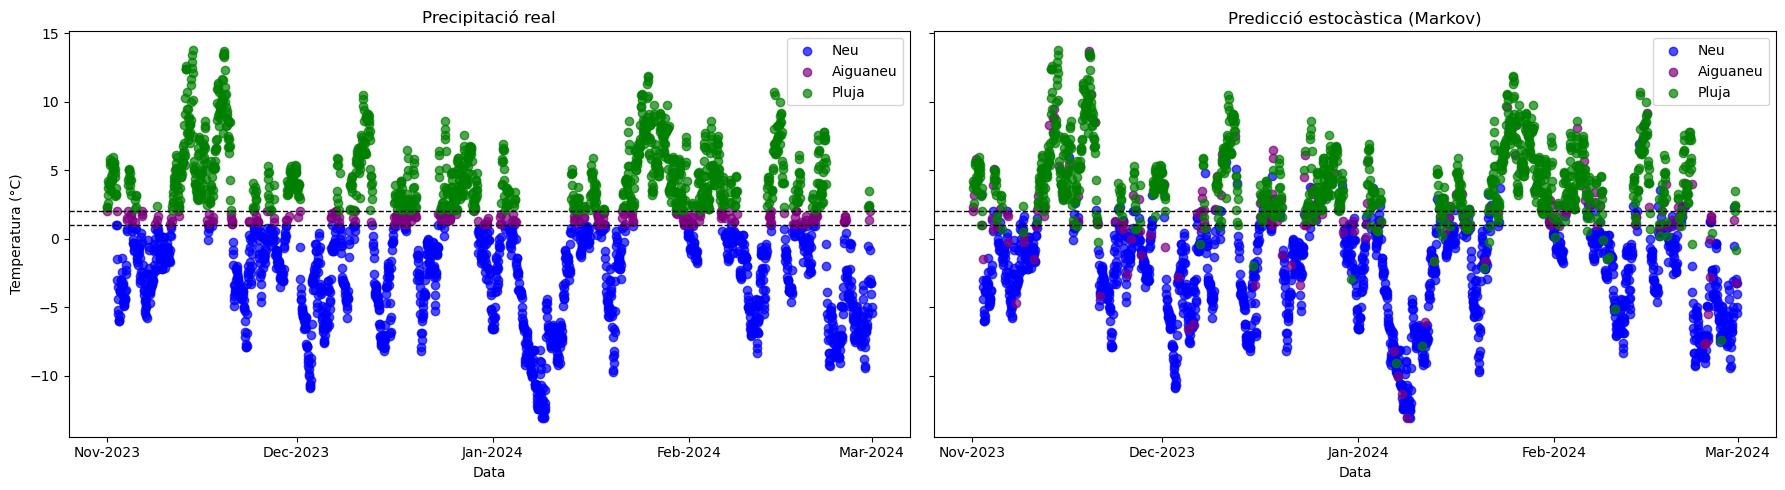

In [45]:
colors = {'N': 'blue', 'A': 'purple', 'P': 'green'}
labels = {'N': 'Neu', 'A': 'Aiguaneu', 'P': 'Pluja'}

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)


# Gràfic 1: precipitació real
for estat in ['N', 'A', 'P']:
    subset = df_test_hiverns[df_test_hiverns['precipitacio'] == estat]
    axes[0].scatter(subset['data'], subset['valor'], label=labels[estat],
                    color=colors[estat], alpha=0.7)
axes[0].set_title("Precipitació real")
axes[0].set_xlabel("Data")
axes[0].set_ylabel("Temperatura (°C)")
# axes[0].grid(True)
axes[0].legend()
axes[0].axhline(1, color='black', linestyle='--', linewidth=1)
axes[0].axhline(2, color='black', linestyle='--', linewidth=1)
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  


# Gràfic 2: predicció estocàstica
for estat in ['N', 'A', 'P']:
    subset = df_test_hiverns[df_test_hiverns['prediccio_estocastica'] == estat]
    axes[1].scatter(subset['data'], subset['valor'], label=labels[estat],
                    color=colors[estat], alpha=0.7)
axes[1].set_title("Predicció estocàstica (Markov)")
axes[1].set_xlabel("Data")
# axes[1].grid(True)
axes[1].legend()
axes[1].axhline(1, color='black', linestyle='--', linewidth=1)
axes[1].axhline(2, color='black', linestyle='--', linewidth=1)
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.tight_layout()
plt.show()


In [46]:
accuracy = (df_test_hiverns['precipitacio'][1:] == df_test_hiverns['prediccio_estocastica'][1:]).mean()
print(f"Accuracy general: {accuracy:.2%}")


Accuracy general: 85.50%


In [63]:
print("Accuracy per classe:")
print(classification_report(
    df_test_hiverns['precipitacio'][1:], 
    df_test_hiverns['prediccio_estocastica'][1:], 
    labels=['N', 'A', 'P'], 
    target_names=['Neu', 'Aiguaneu', 'Pluja']
))


Accuracy per classe:
              precision    recall  f1-score   support

         Neu       0.92      0.93      0.93      1544
    Aiguaneu       0.26      0.27      0.26       219
       Pluja       0.89      0.86      0.88      1140

    accuracy                           0.85      2903
   macro avg       0.69      0.69      0.69      2903
weighted avg       0.86      0.85      0.86      2903



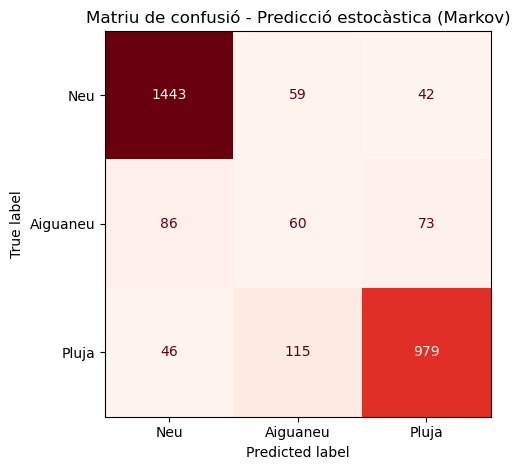

In [60]:
labels = ['N', 'A', 'P']  # en el mateix ordre que les classes
cm = confusion_matrix(df_test_hiverns['precipitacio'][1:], 
                      df_test_hiverns['prediccio_estocastica'][1:], 
                      labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neu', 'Aiguaneu', 'Pluja'])
disp.plot(cmap='Reds', colorbar=False)
plt.title("Matriu de confusió - Predicció estocàstica (Markov)")
plt.grid(False)
plt.tight_layout()
plt.show()


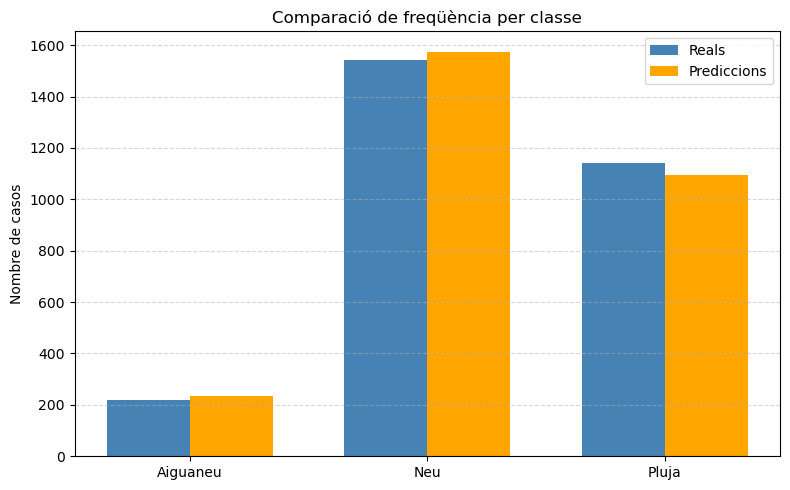

In [64]:
import matplotlib.pyplot as plt

# Comptem valors reals i predites
reals = df_test_hiverns['precipitacio'][1:].value_counts().sort_index()
predites = df_test_hiverns['prediccio_estocastica'][1:].value_counts().sort_index()

# Preparem gràfic
labels = ['Aiguaneu', 'Neu', 'Pluja']
index = ['A', 'N', 'P']

x = range(len(index))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x, [reals.get(i, 0) for i in index], width, label='Reals', color='steelblue')
plt.bar([i + width for i in x], [predites.get(i, 0) for i in index], width, label='Prediccions', color='orange')

plt.xticks([i + width/2 for i in x], labels)
plt.ylabel('Nombre de casos')
plt.title('Comparació de freqüència per classe')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


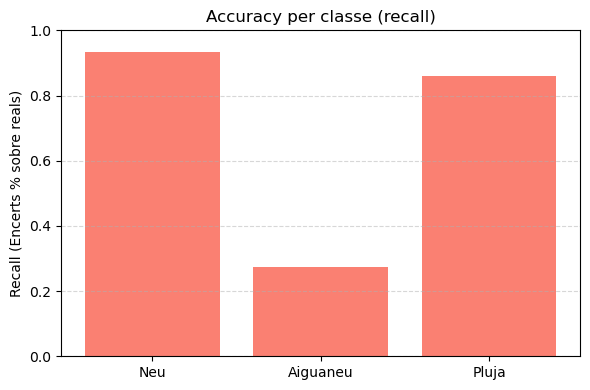

In [65]:
from sklearn.metrics import recall_score

# Percentatge d'encerts per classe (recall)
labels = ['N', 'A', 'P']
recalls = []

for l in labels:
    y_true = df_test_hiverns['precipitacio'][1:] == l
    y_pred = df_test_hiverns['prediccio_estocastica'][1:] == l
    recall = (y_true & y_pred).sum() / y_true.sum()
    recalls.append(recall)

plt.figure(figsize=(6,4))
plt.bar(['Neu', 'Aiguaneu', 'Pluja'], recalls, color='salmon')
plt.ylabel('Recall (Encerts % sobre reals)')
plt.title("Accuracy per classe (recall)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
